In [1]:
from filesender.benchmark import benchmark
from os import environ

read_limit = list(range(1, 10))
req_limit = list(range(1, 10))
results = benchmark(req_limit=req_limit, read_limit=read_limit, apikey=environ["API_KEY"], base_url=environ["BASE_URL"], recipient=environ["RECIPIENT"], username=environ["USERNAME"])

In [ ]:
import pandas as pd
result_df = pd.DataFrame.from_records(results)

Text(0.5, 0.98, 'Memory Usage')

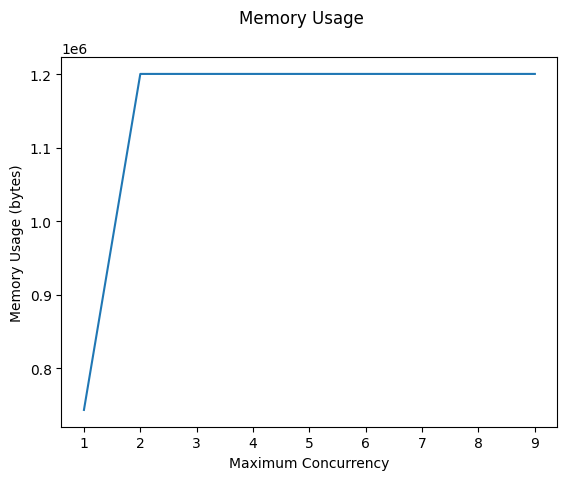

In [2]:
import seaborn as sns
ax.plot(x, [result.memory for result in results])
ax.set_ylabel("Memory Usage (bytes)")
ax.set_xlabel("Maximum Concurrency")
fig.suptitle("Memory Usage")

Text(0.5, 0.98, 'Runtime')

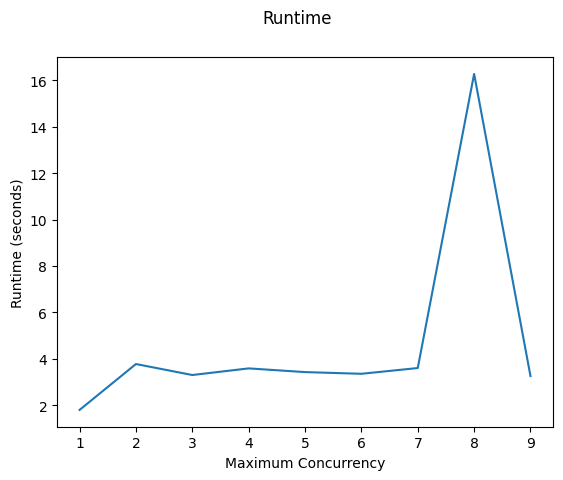

In [3]:
fig, ax = plt.subplots()
ax.plot(x, [result.time for result in results])
ax.set_ylabel("Runtime (seconds)")
ax.set_xlabel("Maximum Concurrency")
fig.suptitle("Runtime")